Zixuan Chen 61665307

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from time import perf_counter as clock
from beautifultable import BeautifulTable

np.random.seed(0)

Here I create a Function object aiming to save effort in calculating gradients and printing results later on. It also keep track of the number of function calls\
By using Function and Symbol form the sympy lib, I can make this object printable, callable and also easily differentiable.\
See comments for details about the implementation

In [2]:
class Function:
    def __init__(self, func_str, symbols, parameter_pos = None):
        '''
            (1) symbols are passed in as a string and seperated by ','
            (2) parameter_pos remembers which variable the function should take. 
                Default is None because the original function takes all variables.
                It is only useful for its partial derivatives functions.
        '''
        self.func = func_str
        
        self.symbols = {}
        for s in symbols.split(','):
            s = s.strip()
            self.symbols[s] = sp.Symbol(s)
          
        self.s = len(self.symbols)
        self.calls = 0
        exec(f'self._f = lambda {symbols}: {func_str}')
        
        self.pos = parameter_pos
        if not self.pos:
            self.pos = list(range(self.s))       
    
    def __repr__(self):
        return self.func
    
    def __str__(self):
        return self.func
    
    def __call__(self, variables):
        ''' to call the function, we only take what need in the variable vector '''
        self.calls += 1
        s = [variables[i] for i in self.pos]
        return self._f(*s)
    
    def diff(self, symbol):
        ''' differentiate using sympy, remember all the varibale positions and return a new Function object '''
        df = str(sp.Function(str(sp.diff(self.func, symbol))))
        sym, pos = [], []
        for i, s in enumerate(self.symbols.keys()):
            if s in df:
                sym.append(s)
                pos.append(i)
        return Function(df, ','.join(sym), pos)

Here I define some helper functions to reduce potential duplicate typing later on

In [3]:
def gradient(f:'Function') -> ['Function']:
    ''' return a gradient vector'''
    return np.array([f.diff(s) for s in f.symbols.keys()])

def compute_gradient(g: ['Function'], x: 'np.array') -> ['value']:
    ''' compute the gradient at given point'''
    return np.array([d(x) for d in g])

def gradient_magnitude(g, x):
    ''' return the length of the gradient vector at point x'''
    return np.sqrt(sum([i(x)**2 for i in g]))

def vector_length(v):
    ''' return the length of a vector'''
    return np.sqrt(sum([i**2 for i in v]))

# 1a Gradient Descent

The algorithm of "backtracking_line_search" comes from the Kochenderfer and Wheeler book (pg.56) Algorithm 4.2, "backtracking_line_search".

In [4]:
def backtracking_line_search(f, f_gradient, start, direction, step_size = 1, p = 0.5, beta = 0.5):
    y, g = f(start), compute_gradient(f_gradient, start)
    
    # a step_size alpha is accepted only when f(x + alpha*d) is below the line f(x) + alpha * beta * gradient * direction
    while f(start + step_size * direction) > (y + beta * step_size * (g.dot(direction))):
        step_size *= p # decrease the step size by a factor if not accepetable 
    return step_size

The basic idea of gradient_descent is:\
Take the opposite of the gradient at point x as direction and normalize it by dividing its length. Then use the direction to calculate the step size using 'backtracking_line_search'. Update the x by step size on the direction and do the whole thing again until ||gradient(x)|| is smaller than a tolerance.\
During the descent process, it will also track the iteration number and the running time. When the stopping criterion is satisfied, it will return the following information:\
(1) Convergence in the last iteration. This is computed using ||step * direction||\
(2) Absolute error. This is computed using the distance of f(x) from 0\
(3) Iteration number\
(4) Running time

In [5]:
def gradient_descent(f : 'Function', x0 : 'np.array', fprime : ['Function'] , tol = 1e-4, b = 0.5):
    time = clock()
    x = x0.copy()
    iteration, step = 0, 0
    
    # main loop
    gm = gradient_magnitude(fprime, x)
    while  gm > tol: 
        iteration += 1
        direction = -compute_gradient(fprime, x) / gm  # normalize
        step = backtracking_line_search(f, fprime, x, direction, beta = b)#; print(step)
        x += step * direction
        gm = gradient_magnitude(fprime, x)

    return vector_length(step * direction), abs(f(x)), iteration, clock() - time

# 1b Conjugate Gradient

For my CG method, I am using Fletcher-Reeves metod: β(k) = G(k) dot G(K) / G(k-1) dot G(k-1)\
                           which is equivilent to ||G(k)||^2 / ||G(k-1)||^2\
The basic ides is similar to the Gradient_descent method, expect that stating from the second iteration, it update the direction based on β and previous direction. <b>Additionally, it reset β and previous direction every 5 iterations.</b>\
Similar to Gradient Descent, when the stopping criterion is satisfied, it will return the following information:\
(1) Convergence in the last iteration. This is computed using ||step * direction||\
(2) Absolute error. This is computed using the distance of f(x) from 0\
(3) Iteration number\
(4) Running time

In [6]:
''' # Old version without restart
def conjugate_gradients(f : 'Function', x0 : 'np.array', fprime : ['Function'] , tol = 0.0005, b = 0.5):
    time = clock()
    x = x0.copy()
    iteration, step = 0, 0
    beta, direction = 0, 0 # both zero in the first iteration, updated in subsequent iterations
    
    # main loop
    gm = gradient_magnitude(fprime, x)
    while  gm > tol: 
        iteration += 1
        direction = -compute_gradient(fprime, x) + beta * direction
        step = backtracking_line_search(f, fprime, x, direction, beta = b)#; print(step)
        
        gm_prev = gm
        x += step * direction
        gm = gradient_magnitude(fprime, x)
        beta = gm**2 / gm_prev**2
  
    return vector_length(step * direction), abs(f(x)), iteration, clock() - time'''

def conjugate_gradients(f : 'Function', x0 : 'np.array', fprime : ['Function'] , tol = 1e-4, b = 0.5):
    time = clock()
    x = x0.copy()
    iteration, step, direction = 0, 0, 0 # initialize them, in case the while loops never run
   
    # main loop
    gm = gradient_magnitude(fprime, x)
    while  gm > tol: 
        beta, direction = 0, 0 # both zero at first, updated in subsequent iterations
        while True:
            iteration += 1
            direction = -compute_gradient(fprime, x) / gm + beta * direction # normalize and conjugate
            step = backtracking_line_search(f, fprime, x, direction, beta = b)#; print(step)

            x += step * direction
            gm_prev = gm
            gm = gradient_magnitude(fprime, x)
            
            if iteration % 5 == 0: # restart, abandon old direction info 
                break
            beta = (gm / gm_prev)**2 #gm**2 / gm_prev**2
            
  
    return vector_length(step * direction), abs(f(x)), iteration, clock() - time

# 1c Test

Here I define two test functions. The second one is a 10-dim Rosenbrock function with a = 1 and b = 5

In [7]:
# 10-dim (x-1)^2
f_str = ' + '.join([f'(x{i} - 1)**2' for i in range(10)])
test_func1 = Function(f_str, ','.join([f'x{i}' for i in range(10)]))

# 10-dim Rosenbrock 
f_str = ' + '.join([f'(1 - x{i})**2 + 5*(x{i+1} - x{i}**2)**2' for i in range(9)])
test_func2 = Function(f_str, ','.join([f'x{i}' for i in range(10)]))\

def print_key(d : dict):
    return str(d.keys())[11:-2]

for i, tf in enumerate([test_func1, test_func2], 1):
    print(f'Test Function {i}: {tf}\nvariables: {print_key(tf.symbols)}\n')

Test Function 1: (x0 - 1)**2 + (x1 - 1)**2 + (x2 - 1)**2 + (x3 - 1)**2 + (x4 - 1)**2 + (x5 - 1)**2 + (x6 - 1)**2 + (x7 - 1)**2 + (x8 - 1)**2 + (x9 - 1)**2
variables: 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'

Test Function 2: (1 - x0)**2 + 5*(x1 - x0**2)**2 + (1 - x1)**2 + 5*(x2 - x1**2)**2 + (1 - x2)**2 + 5*(x3 - x2**2)**2 + (1 - x3)**2 + 5*(x4 - x3**2)**2 + (1 - x4)**2 + 5*(x5 - x4**2)**2 + (1 - x5)**2 + 5*(x6 - x5**2)**2 + (1 - x6)**2 + 5*(x7 - x6**2)**2 + (1 - x7)**2 + 5*(x8 - x7**2)**2 + (1 - x8)**2 + 5*(x9 - x8**2)**2
variables: 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'



The test function defined below will optimize a given function over N starting points, using a given method, and report the results using a BeautifulTable.\
The results include a sample mean and an unbiased estimate of population std for Convergence Measure, absolute error, iteration number and running time.\
In this problem, I set N = 50 and each point is a 10-dim vector ranging from -50 to 5. The range covers mostly negative numbers because due to the property of Rosenbrock's function, a positive location will largely increase the running time. Thus, I only allow a few and small positive numbers.

In [8]:
def Test_Method(method, test_func, init_pt, test_fprime, sample_size):
    result = np.array([method(test_func, init_pt[i], test_fprime) for i in range(sample_size)])

    table = BeautifulTable()
    table.set_style(BeautifulTable.STYLE_COMPACT)
    table.column_headers = [str(test_func)]
    
    report = BeautifulTable()
    table.append_row([report])
    report.column_headers = ["Convergence Measure\n||x` - x||", "|error|\nDistant from 0", "Iteration", "time"]
    
    row = []
    for i in range(result.shape[1]):
        m = np.mean(result[:,i])  # sample mean
        s = np.sqrt(sum([(k - m)**2 for k in result[:,i]]) / (sample_size - 1)) # unbiased estimate of population std
        row.append('mean:{:.3e}\nstd:{:.3e}'.format(m,s))
    report.append_row(row)
    return table

In [9]:
sample_size = 50
N = np.random.uniform(-50, 5, (sample_size, 10))

for func in [test_func1, test_func2]:
    for method in [gradient_descent, conjugate_gradients]:
        print('Method: ', method.__name__)
        print(Test_Method(method, func, N, gradient(func), sample_size))
        print() # empty line

Method:  gradient_descent
 (x0 - 1)**2 + (x1 - 1)**2 + (x2 - 1)**2 + (x3 - 1)**2 + (x4 - 1)**2 + (x5 - 1) 
          **2 + (x6 - 1)**2 + (x7 - 1)**2 + (x8 - 1)**2 + (x9 - 1)**2           
--------------------------------------------------------------------------------
   +---------------------+----------------+----------------+----------------+   
   | Convergence Measure |    |error|     |   Iteration    |      time      |   
   |     ||x` - x||      | Distant from 0 |                |                |   
   +---------------------+----------------+----------------+----------------+   
   |   mean:6.049e-04    | mean:9.383e-10 | mean:9.550e+01 | mean:7.824e-03 |   
   |    std:2.255e-03    | std:7.736e-10  | std:1.693e+01  | std:1.424e-03  |   
   +---------------------+----------------+----------------+----------------+   

Method:  conjugate_gradients
 (x0 - 1)**2 + (x1 - 1)**2 + (x2 - 1)**2 + (x3 - 1)**2 + (x4 - 1)**2 + (x5 - 1) 
          **2 + (x6 - 1)**2 + (x7 - 1)**2 + (x8 - 1)*

From the tables, we can see both methods converged very well and have very little error. In terms of efficiency, the CG method with restart frequency 5 is more preferable because it takes less iteration to converge and runs faster than the GD method.

## Extra Credit

In this problem, I am trying to test the influence of line search on the performance of both methods. I will try to move the First Wolfe Condition parameter from 0.1 to 0.9, and observe how the iteration number is depended on it.
For the starting points I choose 20 vectors with variables from -5 to 5.

Test Function 1
Method:  gradient_descent
Sample mean of Iterations(Y-axis) over First Wolfe Condition(X-axis) for Function 1


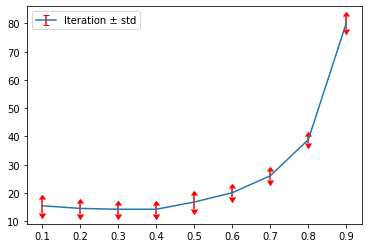

Method:  conjugate_gradients
Sample mean of Iterations(Y-axis) over First Wolfe Condition(X-axis) for Function 1


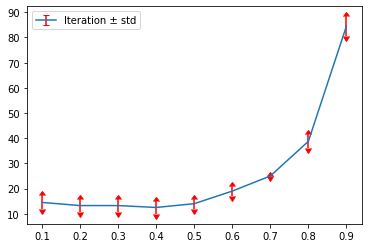

Test Function 2
Method:  gradient_descent
Sample mean of Iterations(Y-axis) over First Wolfe Condition(X-axis) for Function 2


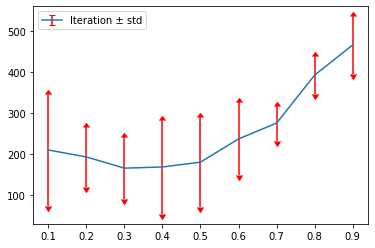

Method:  conjugate_gradients
Sample mean of Iterations(Y-axis) over First Wolfe Condition(X-axis) for Function 2


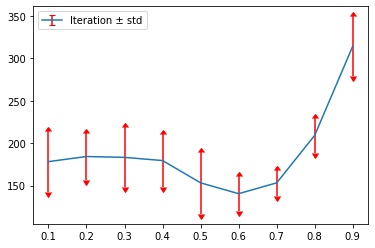

In [10]:
beta = np.array(list(range(1,10))) / 10
sample_size = 20
N = np.random.uniform(-5, 5, (sample_size, 10))

for i, func in enumerate([test_func1, test_func2], 1):
    print('Test Function', i)
    print('==================')
    for method in [gradient_descent, conjugate_gradients]:
        print('Method: ', method.__name__)
        mean, std = [], []
        for b in beta:
            result = np.array([method(func, N[i], gradient(func), b = b)[2] for i in range(sample_size)])
            m = np.mean(result)
            mean.append(m)  # sample mean
            std.append(np.sqrt(sum([(k - m)**2 for k in result]) / (sample_size - 1))) # unbiased estimate of population std
        print('Sample mean of Iterations(Y-axis) over First Wolfe Condition(X-axis) for Function', i)
        plt.errorbar(beta, mean, yerr = std, ecolor = 'red', uplims=True, lolims=True, label = 'Iteration ± std')
        plt.legend()
        plt.show()                        

These plots suggest the ideal value for the first wolfe condition parameter is between 0.4 and 0.6 because the performance of both methods is the best in this region.